#Imprort libarireries

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import *
import xgboost as xgb


In [ ]:
%cd "/content/drive/MyDrive/course/Năm_4/Học Kỳ 7/DS300.M1_Hkhuynngh/Project/data_final"

[Errno 2] No such file or directory: '/content/drive/MyDrive/course/Năm_4/Học Kỳ 7/DS300.M1_Hkhuynngh/Project/data_final'
/content


#Read data

In [ ]:
colnames = ["CustID", "ProductID", "Ratings", "timestamp"]
Train_Data = pd.read_csv("/content/drive/MyDrive/course/Năm_4/Học Kỳ 7/DS300.M1_Hkhuynngh/Project/data_final/ratings_Musical_Instruments_train.csv",header=0, names=colnames)
Test_Data = pd.read_csv("/content/drive/MyDrive/course/Năm_4/Học Kỳ 7/DS300.M1_Hkhuynngh/Project/data_final/ratings_Musical_Instruments_test.csv",header=0, names=colnames)

In [ ]:
len(Train_Data)

8000

In [ ]:
len(Test_Data)

2000

In [ ]:
len(Train_Data["CustID"].unique())

7821

In [ ]:
len(Train_Data["ProductID"].unique())

5585

In [ ]:
len(Test_Data["ProductID"].unique())

1161

In [ ]:
len(Test_Data["CustID"].unique())

1244

In [ ]:
len(Train_Data["CustID"].unique())

##Drop data

##Label data

In [ ]:
from sklearn.preprocessing import LabelEncoder
Cust = LabelEncoder()
Prod = LabelEncoder()

Train_Data["CustID"]   = Cust.fit_transform(Train_Data["CustID"])
Train_Data["ProductID"]= Prod.fit_transform(Train_Data["ProductID"])


Test_Data["CustID"]   = Cust.transform(Test_Data["CustID"])
Test_Data["ProductID"]= Prod.transform(Test_Data["ProductID"])



#Data pre-processing

##Creating USER-ITEM sparse matrix from data frame

In [ ]:
def creating_spares_matric(data="train"):
    if data=="train":
        startTime = datetime.now()
        print("Creating USER_ITEM sparse matrix for train Data")
        if os.path.isfile("/content/TrainUISparseData.npz"):
            print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
            TrainUISparseData = sparse.load_npz("/content/TrainUISparseData.npz")
            print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
            
        else:
            print("We are creating sparse data")
            TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.ProductID)))
            print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
            print("Saving it into disk for furthur usage.")
            sparse.save_npz("/content/TrainUISparseData.npz", TrainUISparseData)
            print("Done\n")
        print(datetime.now() - startTime)
        return TrainUISparseData
    elif data=="test":
   
        startTime = datetime.now()
        print("Creating USER_ITEM sparse matrix for test Data")
        if os.path.isfile("/content/TestUISparseData.npz"):
            print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
            TestUISparseData = sparse.load_npz("/content/TestUISparseData.npz")
            print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
        else:
            print("We are creating sparse data")
            TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.ProductID)))
            print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
            print("Saving it into disk for furthur usage.")
            sparse.save_npz("/content/TestUISparseData.npz", TestUISparseData)
            print("Done\n")
            print(datetime.now() - startTime)
        return TestUISparseData

In [ ]:
TrainUISparseData = creating_spares_matric(data="train")
TestUISparseData  = creating_spares_matric(data="test")

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (7821, 5585)
Saving it into disk for furthur usage.
Done

0:00:00.024820
Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (7819, 5553)
Saving it into disk for furthur usage.
Done

0:00:00.006126


In [ ]:
TestUISparseData.shape

(7819, 5553)

In [ ]:
TrainUISparseData.shape

(7821, 5585)

In [ ]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()
print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.98168510118467% 


In [ ]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.9953937117763% 


##Feature engineering data

In [ ]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of product if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [ ]:
globalAvgProduct = getAverageRatings(TrainUISparseData, False)
globalAvgUsers = getAverageRatings(TrainUISparseData, True)

In [ ]:
sample_train_users, sample_train_product, sample_train_ratings = sparse.find(TrainUISparseData)

In [ ]:
if os.path.isfile("/content/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("/content/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, product, rating in zip(sample_train_users, sample_train_product, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(product) #appending product ID
            row.append(TrainUISparseData.sum()/TrainUISparseData.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "product" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(TrainUISparseData[user], TrainUISparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainUISparseData[similar_users_indices, product].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgProduct[product]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "product" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "product" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar products with "product"------------------#
            similar_products = cosine_similarity(TrainUISparseData[:,product].T, TrainUISparseData.T).ravel()
            similar_products_indices = np.argsort(-similar_products)[1:]
            similar_products_ratings = TrainUISparseData[user, similar_products_indices].toarray().ravel()
            top_similar_product_ratings = list(similar_products_ratings[similar_products_ratings != 0][:5])
            top_similar_product_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_product_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_product_ratings)
            
 #----------------------------------Appending "user" average, "product" average & rating of "user""product"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgProduct[product])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 8000 rows
Done for 2000. Time elapsed: 0:00:09.373024
Done for 4000. Time elapsed: 0:00:18.107505
Done for 6000. Time elapsed: 0:00:26.655761
Done for 8000. Time elapsed: 0:00:35.303973
Total Time for 8000 rows = 0:00:35.305170


In [ ]:
Train_Reg = pd.read_csv("/content/Train_Regression.csv", names = ["User_ID", "product_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "product_Average", "Rating"])
Train_Reg[:20]

In [ ]:
Train_Reg = pd.read_csv("/content/Train_Regression.csv", names = ["User_ID", "product_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "product_Average", "Rating"])
Train_Reg[100:200]

In [ ]:
sample_test_users, sample_test_product, sample_test_ratings = sparse.find(TestUISparseData)

In [ ]:
if os.path.isfile("/content/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("/content/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, product, rating in zip(sample_test_users, sample_test_product, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(product) #appending product ID
            row.append(TrainUISparseData.sum()/TrainUISparseData.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "product" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(TrainUISparseData[user], TrainUISparseData).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = TrainUISparseData[similar_users_indices, product].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgProduct[product]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "product" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "product" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new product#########    
            except(IndexError, KeyError):
                global_average_train_rating = [TrainUISparseData.sum()/TrainUISparseData.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar products with "product"-----------------------#
            try:
                similar_products = cosine_similarity(TrainUISparseData[:,product].T, TrainUISparseData.T).ravel()
                similar_products_indices = np.argsort(-similar_products)[1:]
                similar_products_ratings = TrainUISparseData[user, similar_products_indices].toarray().ravel()
                top_similar_product_ratings = list(similar_products_ratings[similar_products_ratings != 0][:5])
                top_similar_product_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_product_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_product_ratings)
            #########Cold Start Problem, for a new user or a new product#########
            except(IndexError, KeyError):
                global_average_train_rating = [TrainUISparseData.sum()/TrainUISparseData.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "product" average & rating of "user""product"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgProduct[product])
            except(KeyError):
                global_average_train_rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 2000 rows
Done for 100. Time elapsed: 0:00:00.499768
Done for 200. Time elapsed: 0:00:00.972046
Done for 300. Time elapsed: 0:00:01.464800
Done for 400. Time elapsed: 0:00:01.985937
Done for 500. Time elapsed: 0:00:03.098229
Done for 600. Time elapsed: 0:00:04.465853
Done for 700. Time elapsed: 0:00:05.179146
Done for 800. Time elapsed: 0:00:05.629832
Done for 900. Time elapsed: 0:00:06.083071
Done for 1000. Time elapsed: 0:00:06.557512
Done for 1100. Time elapsed: 0:00:07.046185
Done for 1200. Time elapsed: 0:00:07.601547
Done for 1300. Time elapsed: 0:00:08.067976
Done for 1400. Time elapsed: 0:00:08.563690
Done for 1500. Time elapsed: 0:00:09.040011
Done for 1600. Time elapsed: 0:00:09.534260
Done for 1700. Time elapsed: 0:00:09.991592
Done for 1800. Time elapsed: 0:00:10.489495
Done for 1900. Time elapsed: 0:00:10.930232
Done for 2000. Time elapsed: 0:00:11.406731
Total Time for 2000 rows = 0:00:11.407849


In [ ]:
Test_Reg = pd.read_csv("/content/Test_Regression.csv", names = ["User_ID", "product_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "product_Average", "Rating"])
Test_Reg.head()

#Model

In [ ]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [ ]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    y_true =list(y_true.sort_values())
    max  = y_true[-1]
    min  = y_true[0]
    nmae = mae/(max-min)
    return rmse, mse, mae, nmae

In [ ]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mse_train, mae_train, nmae_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MSE = {}".format(mse_train))
    print("MAE = {}".format(mae_train))
    print("NMAE = {}".format(nmae_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MSE": mse_train, "MAE": mse_train, "NMAE": nmae_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mse_test, mae_test, nmae_test= error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MSE = {}".format(mse_test))
    print("MAE = {}".format(mae_test))
    print("NMAE = {}".format(nmae_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MSE": mse_test, "MAE": mse_test, "NMAE": nmae_test, "Prediction": y_pred_test}

        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    # make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result,test_result

In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

[06:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.047816476232601136
MSE = 0.0022864153993029093
MAE = 0.006770452104508877
NMAE = 0.0016926130261272192
--------------------------------------------------
TEST DATA
RMSE = 1.2858328124509995
MSE = 1.6533660215756472
MAE = 0.727734917640686
NMAE = 0.1819337294101715
--------------------------------------------------
Time Taken = 0:00:00.594383


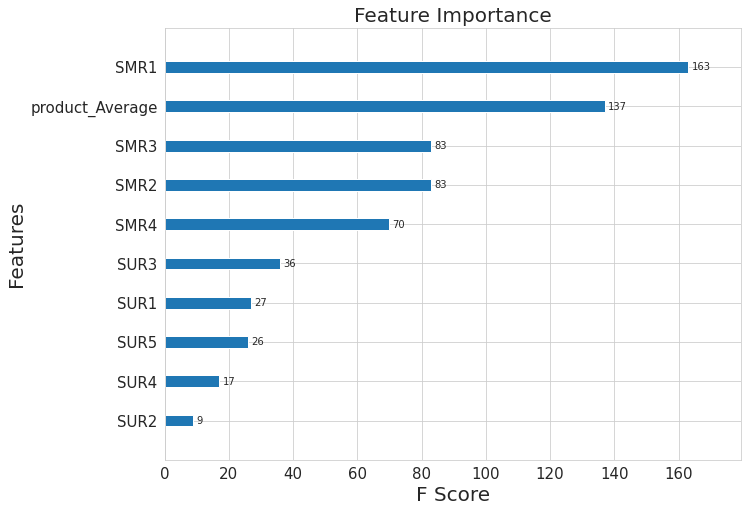

In [ ]:
x_train = Train_Reg.drop(["User_ID", "product_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "product_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result= train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result